<a href="https://colab.research.google.com/github/3hungdc/Customer_Churn_Telco/blob/main/BBC_News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pickle

import nltk
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Đọc Data và Clean dữ liệu

In [ ]:
# Đọc dữ liệu từ folder test
def read_data(data_folder):
    news = []
    types = []
    count = 0
    for root, dirs, files in os.walk(data_folder, topdown=False):
        if len(dirs) != 0:
            folder_file = dirs


    for root, dirs, files in os.walk(data_folder, topdown=False):               
            if len(dirs) == 0:
                for text_file in files:
                    text_file = os.path.join(root, text_file)
                    with open(text_file, errors = 'replace') as f:
                        text = f.readlines()
                    text = " ".join(text)
                    news.append(text)
                    types.append(folder_file[count])
                count += 1
    df = {'Text': news,'Category': types}
    df = pd.DataFrame(df)
    return df


In [ ]:
df = read_data('./Data/bbc_train')
df

,Text,Category
0,Ad sales boost Time Warner profit\n \n Quarter...,business
1,Dollar gains on Greenspan speech\n \n The doll...,business
2,Yukos unit buyer faces loan claim\n \n The own...,business
3,High fuel prices hit BA's profits\n \n British...,business
4,Pernod takeover talk lifts Domecq\n \n Shares ...,business
...,...,...
1854,Warnings on woeful wi-fi security\n \n Compani...,tech
1855,"Cebit opens to mobile music tune\n \n Cebit, t...",tech
1856,Game makers get Xbox 2 sneak peek\n \n Microso...,tech
1857,Broadband set to revolutionise TV\n \n BT is s...,tech


CATEGORIES: ['business' 'entertainment' 'politics' 'sport' 'tech'] 

DATA SAMPLE: 

                                                    Text       Category
1736  More power to the people says HP\n \n The digi...           tech
641   Fry set for role in Hitchhiker's\n \n Actor St...  entertainment
1109  Isinbayeva heads for Birmingham\n \n Olympic p...          sport
1620  Portable PlayStation ready to go\n \n Sony's P...           tech
1835  Millions buy MP3 players in US\n \n One in 10 ...           tech
NUMBER OF SAMPLES IN EACH CATEGORY: 



<AxesSubplot:xlabel='Category', ylabel='count'>

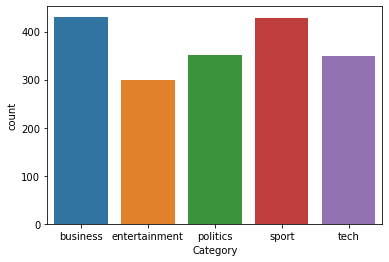

In [ ]:
# Description of the dataset
print('CATEGORIES:', df['Category'].unique(), '\n\nDATA SAMPLE: \n\n', df.sample(n=5))

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(df['Category'])

In [ ]:
# Tokenize
df['text_clean'] = df['Text'].apply(nltk.word_tokenize)
print('Tokenization complete.')
# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
pattern = '[A-Za-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(pattern,item)])

print('Remove numbers, punctuation and special characters.')


# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Tokenization complete.
Stop words removed.
Remove numbers, punctuation and special characters.
Lemmatization complete.
Data cleaning complete.



### Tạo Label và sử dụng CountVectorizer

In [ ]:
# initialize LabelEncoder
lencod = LabelEncoder()
# fit_transform() converts the text to numbers
df['Category'] = lencod.fit_transform(df['Category'])

# Create Searching Table
key_label = df['Category'].unique()
value_label = lencod.inverse_transform(df['Category'].unique())
Category_dictionary = dict(zip(key_label,value_label))
print(Category_dictionary)


#Transform with Countvectorizer
X = df['Text']
y = df['Category']
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X)
X = vectorizer.transform(X)

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}


### Xây dựng Model

In [ ]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def Cross_Valid_Score(model,X,y,cv = 5):
    start = time.time()
    scores = cross_val_score(model,X,y,scoring='accuracy',cv = cv)
    end = time.time()
    return scores.mean(), (end-start)*1000/cv

In [ ]:
def Static_score_model_class(y,y_pred,aver=None):
    accuracy = accuracy_score(y,y_pred)
    recall = recall_score(y,y_pred,average=aver)
    precision = precision_score(y,y_pred,average=aver)
    f1 = f1_score(y,y_pred,average=aver)
    return accuracy, recall, precision, f1

In [ ]:
def ROC_AUC(y,y_prob):
    # calculate roc curves
    fpr, tpr, threshold = roc_curve(y, y_prob)
    # calculate scores
    model_auc = roc_auc_score(y, y_prob)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill' )
    plt.plot(fpr, tpr, marker='.', label='Model - AUC=%.3f' %  (model_auc))
    # show axis labels and the legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show(block=False)
    return


In [ ]:
# Evaluate Models:
models = [ LogisticRegression(),
        MultinomialNB(),
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        SVC()]
scores = []
names = []

for model in models:
    scores.append(Cross_Valid_Score(model,X_train,y_train,cv = 5))
    names.append(model.__class__.__name__)
df_1 = pd.DataFrame(scores,columns=['Score','Time Fit'],index = range(len(models)))
df_1.insert(0,'Model',pd.Series(names))
print(df_1)

                    Model     Score     Time Fit
0      LogisticRegression  0.970407  1337.472343
1           MultinomialNB  0.974451    14.163256
2  RandomForestClassifier  0.952930  1169.382620
3  DecisionTreeClassifier  0.804942   211.844635
4                     SVC  0.946865  2607.839918


In [ ]:
### Choose Naives Bayes

In [ ]:
param = { 'alpha': np.linspace(0.01, 1, 5), 'fit_prior': [True, False] }
model = MultinomialNB()

In [ ]:
# Model_Tunning(models,params,X_train,y_train)
gs = GridSearchCV(model, param, cv=5, error_score=0)
gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=0, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                         'fit_prior': [True, False]})

### Đánh giá Model

In [ ]:

gs.score(X_train, y_train)


0.9939475453934096

In [ ]:
# Đánh giá tập Test
y_pred = gs.predict(X_test)
score,recall,prec,f1 = Static_score_model_class(y_test,y_pred,aver='micro')
print(score,recall,prec,f1)

0.9650537634408602 0.9650537634408602 0.9650537634408602 0.9650537634408602


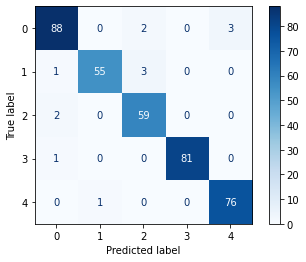

In [ ]:
plot_confusion_matrix(gs,X_test , y_test,cmap=plt.cm.Blues) 

In [ ]:
## Model tốt

In [ ]:
#Ghi Model

def Save_Object(obj,filename):
    with open(filename,'wb') as file:
        pickle.dump(obj,file)
    return

def Load_Object(filename):
    with open(filename,'rb') as file:
        obj = pickle.load(file)
    return obj

In [ ]:
# Đọc dữ liệu từ folder test
def test_files(data_folder):
    news = []
    types = []
    count = 0
    for root, dirs, files in os.walk(data_folder, topdown=False):
        if len(dirs) != 0:
            folder_file = dirs


    for root, dirs, files in os.walk(data_folder, topdown=False):               
            if len(dirs) == 0:
                for text_file in files:
                    text_file = os.path.join(root, text_file)
                    with open(text_file, errors = 'replace') as f:
                        text = f.readlines()
                    text = " ".join(text)
                    news.append(text)
                    types.append(folder_file[count])
                count += 1
    df = {'Text': news,'Category': types}
    df = pd.DataFrame(df)
    return df

In [ ]:
model = gs
Save_Object(model,"bbc_filter.pkl")
Save_Object(vectorizer,"vectorizer.pkl")

### Nguời sử dụng model

In [ ]:
my_model = Load_Object("bbc_filter.pkl")
my_vectorizer = Load_Object("vectorizer.pkl")
Category_dictionary = {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

### Áp dụng model với dữ liệu test

In [ ]:
df = test_files('./Data/bbc_test')
X_new = df['Text']
X_new = my_vectorizer.transform(X_new)
y_pred_new = my_model.predict(X_new)

### Dự đoán phân loại news

In [ ]:
list_pred = []
for i in y_pred_new:
    list_pred.append(Category_dictionary.get(i))
df['predict'] = list_pred
df
df.to_csv('Result.csv')